In [52]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import itertools
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [53]:
FIGURE_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Code/figures/"
DATA_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/"
DATA_LOAD_PATH = DATA_PATH + "original_data/"
INPUT_MODEL_PATH = DATA_PATH + "processed_data/"
MODEL_SAVE_PATH = DATA_PATH + "trained_models/"
RESULTS_PATH = DATA_PATH + "model_results/"

path_to_shapefile = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/ne_110m_admin_0_countries.shp"
world = gpd.read_file(path_to_shapefile)
with open("functions_training_model.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)
df_empirical_Holocene = pd.read_csv(INPUT_MODEL_PATH + "df_empirical_Holocene.csv")
df_global_grid = pd.read_csv(INPUT_MODEL_PATH + "df_global_grid.csv")
df_wind = pd.read_csv(INPUT_MODEL_PATH + "df_wind.csv", usecols=['wind', 'latitude'])

latitude_wind = torch.tensor(df_wind['latitude'].values / 90, dtype=torch.float32)
mean_wind = torch.tensor(df_wind['wind'].values / df_wind['wind'].max(), dtype=torch.float32)


def wind_func(lat_tensor):
    # Interpolazione lineare in PyTorch
    return torch.interp(lat_tensor.flatten(), latitude_wind, mean_wind).unsqueeze(1)





In [54]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.SiLU()
        layer_list = []

        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                layer_list.append(self.activation)
        self.model = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.model(x)


In [55]:
# PDE
D = torch.nn.Parameter(torch.tensor(1.0, requires_grad=True))


def pde_residual(model, x, wind_func, D):
    x.requires_grad_(True)
    u = model(x)

    grad_u = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivate parziali
    du_dx = grad_u[:, 0:1]
    du_dy = grad_u[:, 1:2]

    # Secondi ordini
    d2u_dx2 = autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0][:, 0:1]
    d2u_dy2 = autograd.grad(du_dy, x, grad_outputs=torch.ones_like(du_dy), create_graph=True)[0][:, 1:2]

    # Coefficiente K in funzione della latitudine (seconda colonna di x)
    K = wind_func(x[:, 1:2])

    # Residuo PDE (esempio diffusione anisotropa)
    residual = (-K * du_dx * (1 / torch.cos(x[:, 1:2] * np.pi / 2)) + D * (
        (1 / (torch.cos(x[:, 1:2] * np.pi / 2) ** 2) * d2u_dx2 + d2u_dy2 - torch.tan(x[:, 1:2] * np.pi / 2) * du_dy)))
    return residual


In [56]:
# === PARAMETRI DEL DOMINIO ===
x_min, x_max = -2.0, 2.0
y_min, y_max = -0.89, 0.89

# === 1. DATI OSSERVATI ===
# Assumi che lon/lat siano già scalati correttamente in [-2, 2] e [-0.89, 0.89]
X_obs = torch.tensor(df_empirical_Holocene[['lon', 'lat']].values / 90, dtype=torch.float32)
Y_obs = torch.tensor(df_empirical_Holocene['log_dep_norm'].values.reshape(-1, 1), dtype=torch.float32)

# Verifica range
print("Range X_obs:", X_obs[:, 0].min().item(), X_obs[:, 0].max().item())
print("Range Y_obs:", X_obs[:, 1].min().item(), X_obs[:, 1].max().item())

# === 2. PUNTI INTERNI (PDE) ===
N_pde = 3000

xy_pde = torch.cat([
    torch.rand(N_pde, 1) * (x_max - x_min) + x_min,  # x in [x_min, x_max]
    torch.rand(N_pde, 1) * (y_max - y_min) + y_min  # y in [y_min, y_max]
], dim=1)

# === 3. CONDIZIONI AL CONTORNO DIRICHLET ===

# Nord: y = y_max
N_bc = 200
X_north = torch.rand(N_bc, 1) * (x_max - x_min) + x_min
Y_north = torch.full_like(X_north, y_max)
X_bc_north = torch.cat([X_north, Y_north], dim=1)
Y_bc_north = torch.full((N_bc, 1), -1.0)  # Valore BC nord

# Sud: y = y_min
X_south = torch.rand(N_bc, 1) * (x_max - x_min) + x_min
Y_south = torch.full_like(X_south, y_min)
X_bc_south = torch.cat([X_south, Y_south], dim=1)
Y_bc_south = torch.full((N_bc, 1), -2.0)  # Valore BC sud

# === 4. CONDIZIONI PERIODICHE (x = x_min e x = x_max) ===
N_periodic = 200
Y_periodic = torch.linspace(y_min, y_max, N_periodic).unsqueeze(1)

X_periodic_left = torch.full_like(Y_periodic, x_min)
X_periodic_right = torch.full_like(Y_periodic, x_max)

X_periodic_left = torch.cat([X_periodic_left, Y_periodic], dim=1)
X_periodic_right = torch.cat([X_periodic_right, Y_periodic], dim=1)


Range X_obs: -1.983555555343628 1.996666669845581
Range Y_obs: -0.8888888955116272 0.8763333559036255


In [57]:
# K in funzione della latitudine (normalizzata)
def wind_func(lat_tensor):
    return 1.0 + 0.5 * torch.sin(np.pi * lat_tensor)  # funzione fittizia


In [58]:
def total_loss(model, X_obs, Y_obs, xy_pde, X_bc1, Y_bc1,
               X_bc2, Y_bc2, X_periodic_left, X_periodic_right,
               wind_func, D,
               lambda_obs=5.0, lambda_pde=10.0, lambda_bc1=0.5, lambda_bc2=0.5,
               lambda_per0=1.0, lambda_per1=1.0):
    # Loss osservati
    pred_obs = model(X_obs)
    loss_obs = nn.MSELoss()(pred_obs, Y_obs)

    # PDE residual
    res_pde = pde_residual(model, xy_pde, wind_func, D)
    loss_pde = torch.mean(res_pde ** 2)

    # BC1 Dirichlet (esempio)
    pred_bc1 = model(X_bc1)
    loss_bc1 = nn.MSELoss()(pred_bc1, Y_bc1)

    # BC2 Dirichlet (esempio)
    pred_bc2 = model(X_bc2)
    loss_bc2 = nn.MSELoss()(pred_bc2, Y_bc2)

    # Condizione periodica sul valore (ordine derivata 0)
    u_left = model(X_periodic_left)
    u_right = model(X_periodic_right)
    loss_per0 = nn.MSELoss()(u_left, u_right)

    # Condizione periodica sulla derivata (ordine derivata 1)
    # Calcolo derivata in X_periodic_left e X_periodic_right
    x_left = X_periodic_left.clone().detach().requires_grad_(True)
    x_right = X_periodic_right.clone().detach().requires_grad_(True)

    u_left = model(x_left)
    u_right = model(x_right)

    grad_left = autograd.grad(u_left, x_left, grad_outputs=torch.ones_like(u_left), create_graph=True)[0][:, 0:1]
    grad_right = autograd.grad(u_right, x_right, grad_outputs=torch.ones_like(u_right), create_graph=True)[0][:, 0:1]

    loss_per1 = nn.MSELoss()(grad_left, grad_right)

    # Somma pesata
    total = (lambda_obs * loss_obs + lambda_pde * loss_pde +
             lambda_bc1 * loss_bc1 + lambda_bc2 * loss_bc2 +
             lambda_per0 * loss_per0 + lambda_per1 * loss_per1)

    return total, loss_obs.item(), loss_pde.item(), loss_bc1.item(), loss_bc2.item(), loss_per0.item(), loss_per1.item()


In [59]:
# creo una griglia 1°x1°
# Definisci i range
lon_vals = np.arange(-180, 180, 1)  # Include 180
lat_vals = np.arange(-90, 90, 1)  # Include 90

# Crea la griglia con tutti i punti (lon, lat)
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

# Crea il DataFrame
df_global_grid_1x1 = pd.DataFrame({
    'lon': lon_flat,
    'lat': lat_flat
})

print(f"Griglia creata con {len(df_global_grid_1x1)} punti")

# Opzionale: salva su CSV
#df_global_grid_1x1.to_csv("global_grid_1x1.csv", index=False)


Griglia creata con 64800 punti


In [60]:
# === PARAMETRI DELLE BANDE ===
n_bands = 18
bands_for_training = [0, 1, 3, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]
bands_for_testing = list(set(range(n_bands)) - set(bands_for_training))  # es: [2, 6, 10, 14]

lat_min, lat_max = -0.89, 0.89
band_width = (lat_max - lat_min) / n_bands

# Funzione per assegnare una banda
def assign_band(lat_tensor):
    return ((lat_tensor - lat_min) // band_width).to(torch.int)

# === ASSEGNA BANDE AI DATI OSSERVATI ===
latitudes = X_obs[:, 1]
bands_obs = assign_band(latitudes)
# Costruisci le maschere
train_mask = torch.isin(bands_obs, torch.tensor(bands_for_training))
val_mask = ~train_mask

# SEPARA I DATI
X_obs_train = X_obs[train_mask]
Y_obs_train = Y_obs[train_mask]
X_obs_val = X_obs[val_mask]
Y_obs_val = Y_obs[val_mask]


print(f"Training set: {X_obs_train.shape[0]} punti")
print(f"Validation/Test set: {X_obs_val.shape[0]} punti")

Training set: 329 punti
Validation/Test set: 68 punti


In [61]:
df_empirical_Holocene['lat_norm'] = df_empirical_Holocene['lat'] / 90.0
df_empirical_Holocene['band'] = ((df_empirical_Holocene['lat_norm'] - lat_min) // band_width).astype(int)
df_test = df_empirical_Holocene[df_empirical_Holocene['band'].isin(bands_for_testing)].copy()
print(f"Punti nei dati osservati (Holocene) che cadono nelle bande di TEST: {len(df_test)}")

df_global_grid_1x1['lat_norm'] = df_global_grid_1x1['lat'] / 90.0
df_global_grid_1x1['band'] = ((df_global_grid_1x1['lat_norm'] - lat_min) // band_width).astype(int)
df_grid_test = df_global_grid_1x1[df_global_grid_1x1['band'].isin(bands_for_testing)].copy()
print(f"Punti nella griglia delle bande di TEST: {len(df_grid_test)}")


Punti nei dati osservati (Holocene) che cadono nelle bande di TEST: 68
Punti nella griglia delle bande di TEST: 12960


In [62]:
# 4. Allena modello con i  pesi e salva la storia delle loss
model = PINN(layers=[2, 32, 32, 32, 32, 32, 1])
D = torch.nn.Parameter(torch.tensor(1.0, requires_grad=True))
params = list(model.parameters()) + [D]
optimizer_adam = torch.optim.Adam(params, lr=1e-4)
#scheduler: scende da 1e-3 fino a 1e-5 in 10000 epoche
scheduler = ReduceLROnPlateau(
    optimizer_adam, mode='min', factor=0.5, patience=500,
    min_lr=1e-7, )

# 3. Definisci i pesi (lambda) manualmente
lambda_obs = 20
lambda_pde = 8
lambda_bc1 = 3
lambda_bc2 = 3
lambda_per0 = 1
lambda_per1 = 1

epochs_adam = 15000
loss_history = []

for epoch in range(epochs_adam):
    optimizer_adam.zero_grad()
    loss, l_obs, l_pde, l_bc1, l_bc2, l_per0, l_per1 = total_loss(
        model, X_obs_train, Y_obs_train, xy_pde, X_bc_north, Y_bc_north, X_bc_south, Y_bc_south,
        X_periodic_left, X_periodic_right, wind_func, D,
        lambda_obs=lambda_obs, lambda_pde=lambda_pde, lambda_bc1=lambda_bc1, lambda_bc2=lambda_bc2,
        lambda_per0=lambda_per0, lambda_per1=lambda_per1
    )
    loss.backward()
    optimizer_adam.step()
    scheduler.step(loss.item())
    with torch.no_grad():
        pred_val_epoch = model(X_obs_val)
        val_loss_epoch = nn.MSELoss()(pred_val_epoch, Y_obs_val).item()
    loss_history.append([loss.item(),
                         lambda_obs * l_obs,
                         lambda_pde * l_pde,
                         lambda_bc1 * l_bc1 + lambda_bc2 * l_bc2,
                         lambda_per0 * l_per0,
                         lambda_per1 * l_per1,
                         val_loss_epoch
                         ])

    if epoch % 500 == 0:
        current_lr = optimizer_adam.param_groups[0]['lr']
        print(
            f"Adam | Epoch {epoch:5d} | Total: {loss.item():.5f} | Obs: {l_obs:.5f} | PDE: {l_pde:.5f} | " f"BC: {(l_bc1 + l_bc2):.5f} | Per0: {l_per0:.5f} | Per1: {l_per1:.5f} | "
              f"Val: {val_loss_epoch:.5f}")



Adam | Epoch     0 | Total: 37.80349 | Obs: 1.06573 | PDE: 0.00000 | BC: 5.49630 | Per0: 0.00000 | Per1: 0.00000 | Val: 0.72098
Adam | Epoch   500 | Total: 27.18123 | Obs: 0.94940 | PDE: 0.29959 | BC: 1.86535 | Per0: 0.17819 | Per1: 0.02231 | Val: 0.91079
Adam | Epoch  1000 | Total: 24.43777 | Obs: 0.84106 | PDE: 0.33809 | BC: 1.52597 | Per0: 0.13846 | Per1: 0.19549 | Val: 0.88942
Adam | Epoch  1500 | Total: 23.96352 | Obs: 0.82442 | PDE: 0.31227 | BC: 1.54314 | Per0: 0.13545 | Per1: 0.21217 | Val: 0.88242
Adam | Epoch  2000 | Total: 23.37358 | Obs: 0.79403 | PDE: 0.32773 | BC: 1.50669 | Per0: 0.12327 | Per1: 0.22779 | Val: 0.84289
Adam | Epoch  2500 | Total: 22.01149 | Obs: 0.73286 | PDE: 0.39307 | BC: 1.32486 | Per0: 0.10678 | Per1: 0.12833 | Val: 0.75057
Adam | Epoch  3000 | Total: 21.17923 | Obs: 0.70676 | PDE: 0.42136 | BC: 1.16176 | Per0: 0.10147 | Per1: 0.08634 | Val: 0.71807
Adam | Epoch  3500 | Total: 20.29885 | Obs: 0.67702 | PDE: 0.44647 | BC: 1.01037 | Per0: 0.09449 | Per1:

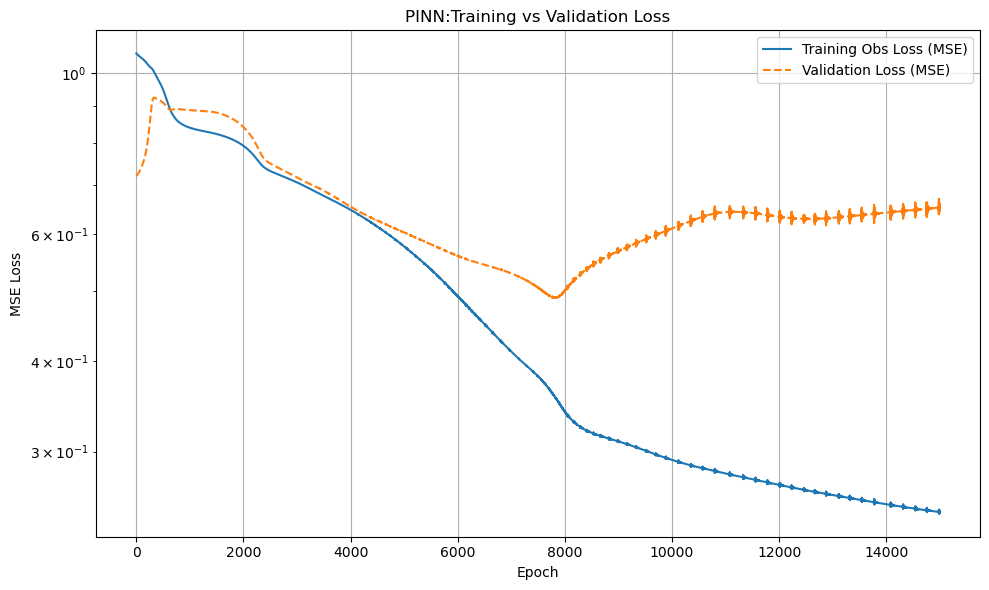

In [63]:
loss_array = np.array(loss_history)  # Ora è 2D con shape (epochs, 7)

plt.figure(figsize=(10, 6))
plt.plot(loss_array[:, 1] / lambda_obs, label='Training Obs Loss (MSE)', linewidth=1.5)
plt.plot(loss_array[:, -1], label='Validation Loss (MSE)', linestyle='--',  linewidth=1.5)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("PINN:Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

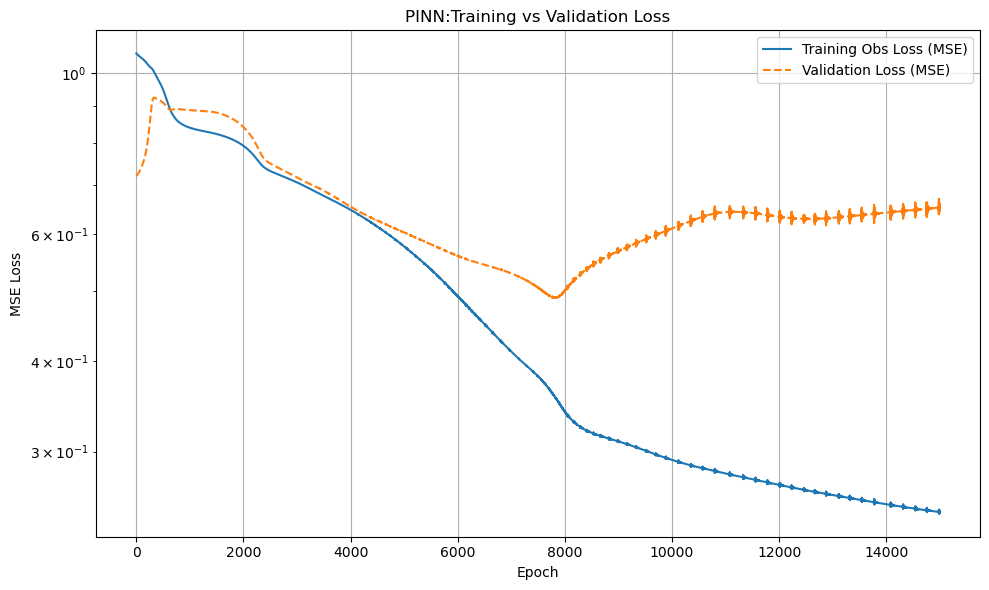

In [64]:
loss_array = np.array(loss_history)  # Ora è 2D con shape (epochs, 7)

plt.figure(figsize=(10, 6))
plt.plot(loss_array[:, 1] / lambda_obs, label='Training Obs Loss (MSE)', linewidth=1.5)
plt.plot(loss_array[:, -1], label='Validation Loss (MSE)', linestyle='--', linewidth=1.5)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("PINN:Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
final_train_obs_loss = loss_array[-1, 1] / lambda_obs
final_val_loss = loss_array[-1, -1]

print(f"Final Training Obs Loss (MSE PINN): {final_train_obs_loss:.5f}")
print(f"Final Validation Loss (MSE PINN): {final_val_loss:.5f}")
print(f"Difference (Val - Train): {final_val_loss - final_train_obs_loss:.5f}")


Final Training Obs Loss (MSE PINN): 0.24725
Final Validation Loss (MSE PINN): 0.65268
Difference (Val - Train): 0.40543


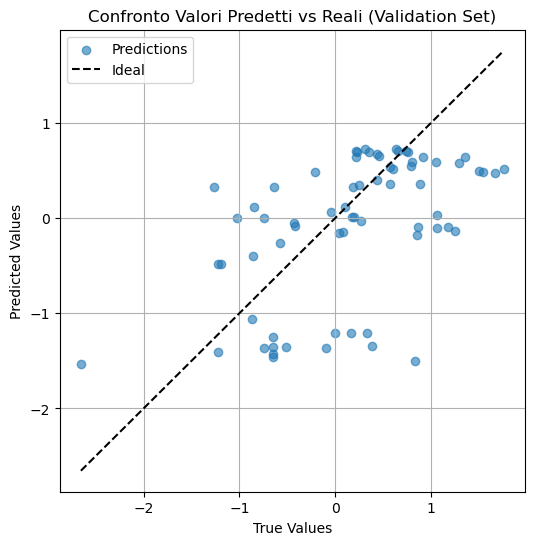

In [66]:
#PINN
pred_val = model(X_obs_val).detach().numpy()
true_val = Y_obs_val.numpy()

plt.figure(figsize=(6, 6))
plt.scatter(true_val, pred_val, alpha=0.6, label='Predictions')
plt.plot([true_val.min(), true_val.max()], [true_val.min(), true_val.max()], 'k--', label='Ideal')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Confronto Valori Predetti vs Reali (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()


In [67]:
# Definizione semplice della NN (uguale alla PINN ma senza PDE/BC)
class SimpleNN(nn.Module):
    def __init__(self, layers):
        super(SimpleNN, self).__init__()
        self.activation = nn.SiLU()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                layer_list.append(self.activation)
        self.model = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.model(x)


# Istanzia modello
model_nn = SimpleNN(layers=[2, 32, 32, 32, 32, 32, 1])
params = list(model_nn.parameters())
# Ottimizzatore e loss (solo osservati)
optimizer_nn = torch.optim.Adam(params, lr=1e-4)
criterion = nn.MSELoss()

epochs_nn = 15000
loss_history_nn = []

for epoch in range(epochs_nn):
    optimizer_nn.zero_grad()
    pred_train = model_nn(X_obs_train)
    loss_train = criterion(pred_train, Y_obs_train)
    loss_train.backward()
    optimizer_nn.step()

    with torch.no_grad():
        pred_val_epoch = model_nn(X_obs_val)
        loss_val = criterion(pred_val_epoch, Y_obs_val).item()

    loss_history_nn.append([loss_train.item(),loss_val])
    if epoch % 500 == 0:
       print(f"NN puro - Epoch {epoch} | Train Loss: {loss_train.item():.6f} | Val Loss: {loss_val:.6f}")


NN puro - Epoch 0 | Train Loss: 1.065561 | Val Loss: 0.820871
NN puro - Epoch 500 | Train Loss: 0.582729 | Val Loss: 0.630759
NN puro - Epoch 1000 | Train Loss: 0.514854 | Val Loss: 0.618331
NN puro - Epoch 1500 | Train Loss: 0.441620 | Val Loss: 0.567610
NN puro - Epoch 2000 | Train Loss: 0.357453 | Val Loss: 0.525990
NN puro - Epoch 2500 | Train Loss: 0.303007 | Val Loss: 0.454275
NN puro - Epoch 3000 | Train Loss: 0.259546 | Val Loss: 0.427887
NN puro - Epoch 3500 | Train Loss: 0.234196 | Val Loss: 0.444233
NN puro - Epoch 4000 | Train Loss: 0.208902 | Val Loss: 0.421930
NN puro - Epoch 4500 | Train Loss: 0.164572 | Val Loss: 0.456927
NN puro - Epoch 5000 | Train Loss: 0.143244 | Val Loss: 0.613298
NN puro - Epoch 5500 | Train Loss: 0.131692 | Val Loss: 0.908688
NN puro - Epoch 6000 | Train Loss: 0.119889 | Val Loss: 1.217443
NN puro - Epoch 6500 | Train Loss: 0.110307 | Val Loss: 1.531146
NN puro - Epoch 7000 | Train Loss: 0.104863 | Val Loss: 1.663165
NN puro - Epoch 7500 | Train 

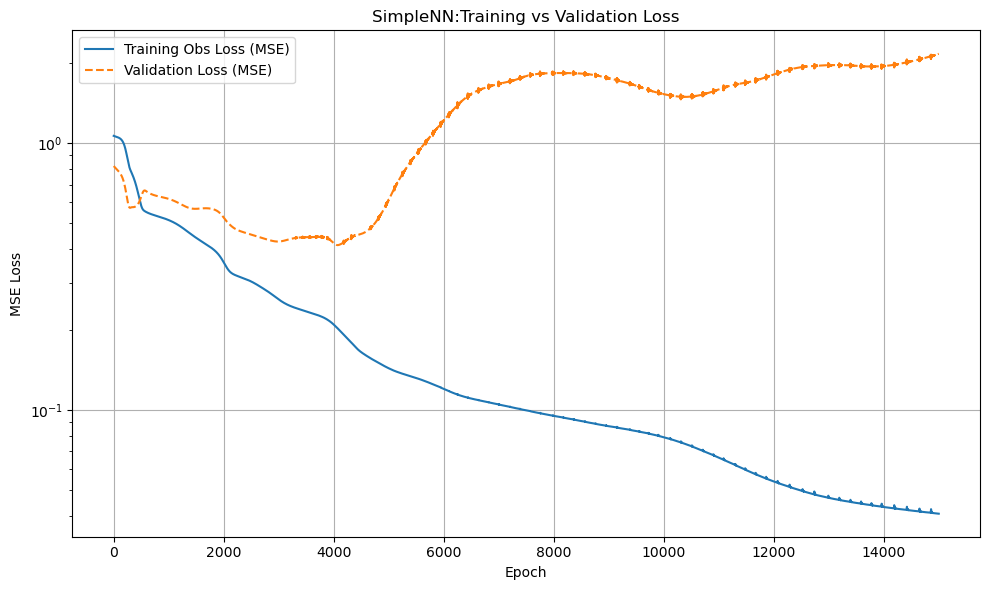

In [68]:
# Converti a numpy e plottalo
loss_array_nn = np.array(loss_history_nn)

plt.figure(figsize=(10, 6))
plt.plot(loss_array_nn[:, 0], label='Training Obs Loss (MSE)', linewidth=1.5)
plt.plot(loss_array_nn[:, -1], label='Validation Loss (MSE)', linestyle='--', linewidth=1.5)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("SimpleNN:Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [69]:
# Confronto numerico
final_train_loss_nn = loss_array_nn [-1, 0]
final_val_loss_nn = loss_array_nn[-1, -1]

print(f"Final Training Obs Loss (MSE): {final_train_loss_nn:.5f}")
print(f"Final Validation Loss (MSE): {final_val_loss_nn:.5f}")
print(f"Difference (Val - Train): {final_val_loss_nn - final_train_loss_nn:.5f}")

Final Training Obs Loss (MSE): 0.04082
Final Validation Loss (MSE): 2.16333
Difference (Val - Train): 2.12251


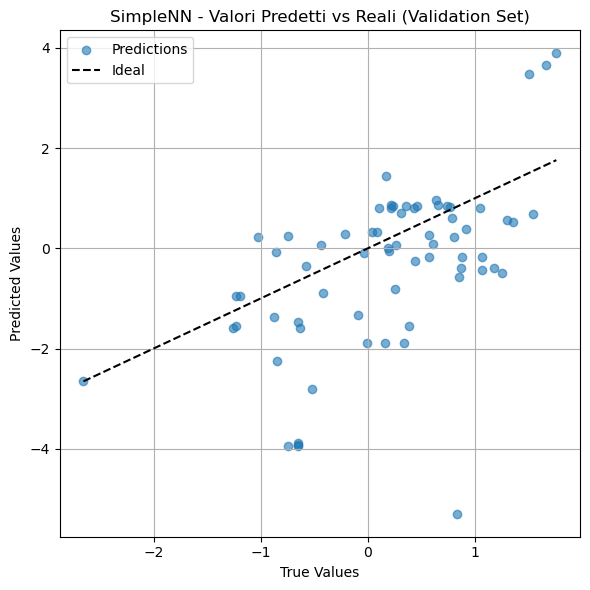

In [70]:
# Previsioni su validation set
pred_val_nn = model_nn(X_obs_val).detach().numpy()
true_val_nn = Y_obs_val.numpy()

plt.figure(figsize=(6, 6))
plt.scatter(true_val_nn, pred_val_nn, alpha=0.6, label='Predictions')
plt.plot([true_val_nn.min(), true_val_nn.max()],
         [true_val_nn.min(), true_val_nn.max()],
         'k--', label='Ideal')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("SimpleNN - Valori Predetti vs Reali (Validation Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
with open("functions_plot_calculations.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)

In [72]:

def calculate_save_df_torch(model, df_to_predict, mean, std, path, filename, device='cpu'):
    """
    Esegue le predizioni con un modello PyTorch e salva il risultato.

    Args:
        model (torch.nn.Module): Modello PyTorch (PINN o NN).
        df_to_predict (pd.DataFrame): DataFrame con colonne 'lon' e 'lat'.
        mean (float): Media del log_dep per denormalizzare.
        std (float): Deviazione standard del log_dep per denormalizzare.
        path (str): Cartella dove salvare il file.
        filename (str): Nome del file da salvare.
        device (str): 'cpu' o 'cuda' per eseguire il modello.
    """

    # Prepara input (normalizza e converte in tensore)
    coords = df_to_predict[['lon', 'lat']].values / 90.0
    coords_tensor = torch.tensor(coords, dtype=torch.float32).to(device)

    # Metti il modello in evaluation
    model.eval()
    with torch.no_grad():
        preds = model(coords_tensor).cpu().detach().numpy()

    # Denormalizza
    preds_denorm = preds * std + mean

    # Aggiungi colonna al DataFrame
    df_to_predict['PINN_log_dep'] = preds_denorm

    # Salva su CSV
    df_to_predict.to_csv(path + filename, index=False)


In [73]:
mean = df_test['log_dep'].mean()
std = df_test['log_dep'].std()


In [74]:
calculate_save_df_torch(model, df_test, mean, std, RESULTS_PATH, "df_test_pinn_withsplit.csv")
calculate_save_df_torch(model, df_global_grid, mean, std, RESULTS_PATH, "df_test_pinn_grid_withsplit.csv")


In [75]:
df_test_pinn_withsplit = pd.read_csv(
    "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_test_pinn_withsplit.csv")
df_test_pinn_grid_withsplit = pd.read_csv(
    "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_test_pinn_grid_withsplit.csv")

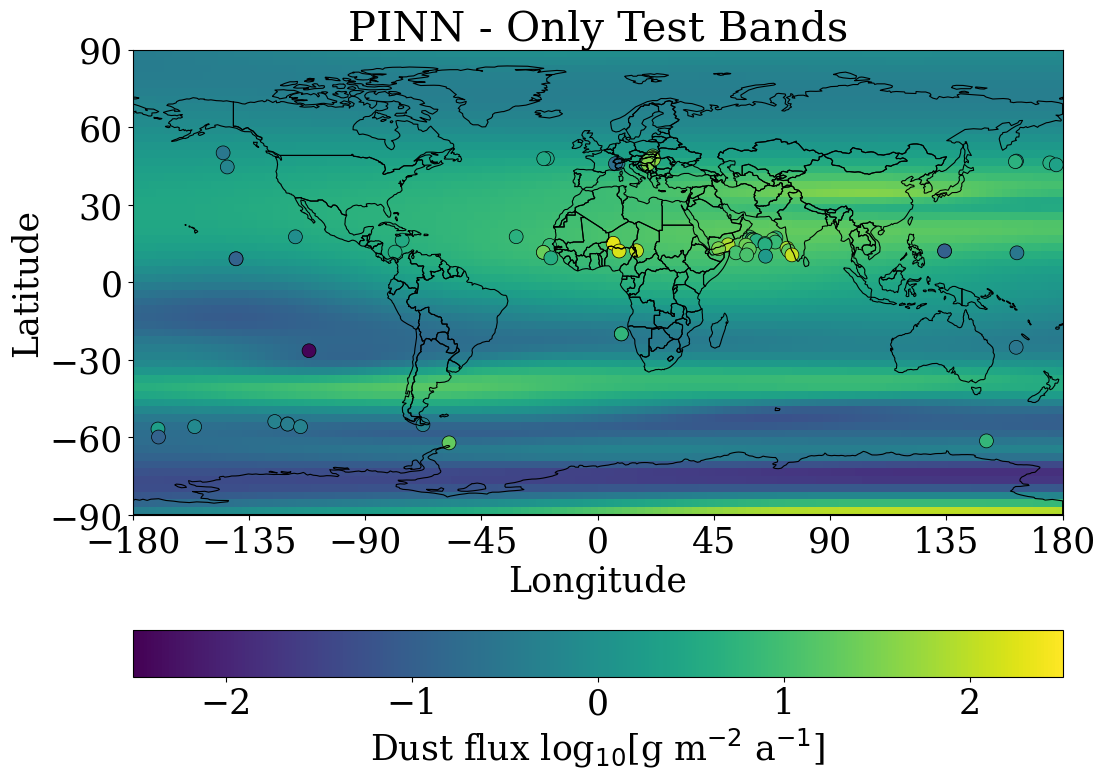

In [76]:
plot_dust_deposition_map(
    df_test_pinn_grid_withsplit,
    df_test_pinn_withsplit,
    title='PINN - Only Test Bands',
    name_to_save='PINN_Test_Bands_Only',
    figure_save_path=FIGURE_PATH,
    label_str='PINN_log_dep',
    limit_bar=2.5
)


In [77]:
calculate_save_df_torch(model_nn, df_test, mean, std, RESULTS_PATH, "df_test_simplenn_withsplit.csv")
calculate_save_df_torch(model_nn, df_global_grid, mean, std, RESULTS_PATH, "df_test_simplenn_grid_withsplit.csv")


In [78]:
df_test_simplenn_withsplit = pd.read_csv(
    "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_test_simplenn_withsplit.csv")
df_test_simplenn_grid_withsplit = pd.read_csv(
    "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_test_simplenn_grid_withsplit.csv")


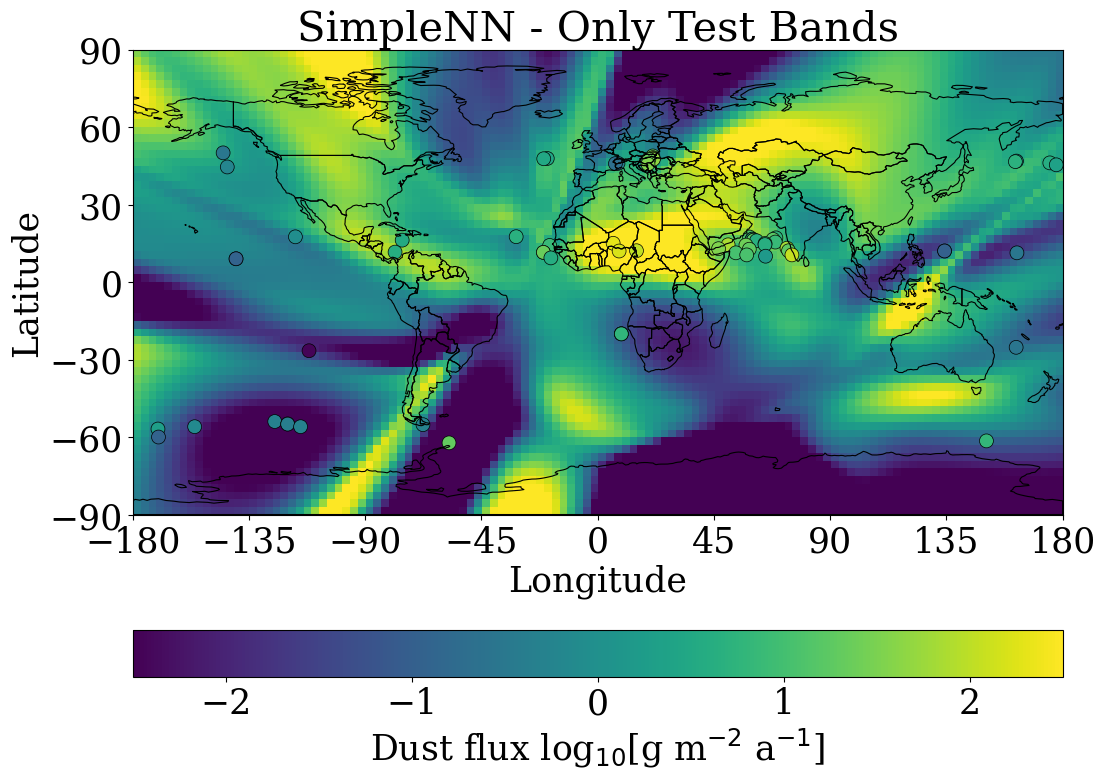

In [79]:
plot_dust_deposition_map(
    df_test_simplenn_grid_withsplit,
    df_test_simplenn_withsplit,
    title='SimpleNN - Only Test Bands',
    name_to_save='SimpleNN_Test_Bands_Only',
    figure_save_path=FIGURE_PATH,
    label_str='PINN_log_dep',
    limit_bar=2.5
)
